Generated data shape: (1500, 6)
Train sequences: (1016, 48, 5)
Val sequences  : (218, 48, 5)
Test sequences : (218, 48, 5)

Training LSTM with hidden_units=32, dropout=0.1
Validation RMSE=0.1506, MAE=0.1215, MAPE=111.00%

Training LSTM with hidden_units=32, dropout=0.2
Validation RMSE=0.1428, MAE=0.1110, MAPE=87.29%

Training LSTM with hidden_units=64, dropout=0.1
Validation RMSE=0.1292, MAE=0.1007, MAPE=124.42%

Training LSTM with hidden_units=64, dropout=0.2
Validation RMSE=0.0920, MAE=0.0745, MAPE=43.17%

Best hyperparameters: {'hidden_units': 64, 'dropout_rate': 0.2}
Best validation scores: {'mse': 0.008464867051271717, 'rmse': 0.09200471211449833, 'mae': 0.07446382725522785, 'mape': 43.16917734108861}

LSTM test metrics:
  MSE: 0.0389
  RMSE: 0.1971
  MAE: 0.1661
  MAPE: 65.9137


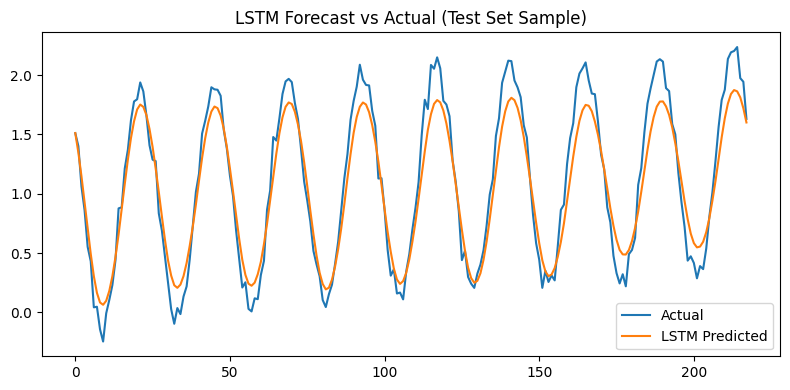


Baseline MLP test metrics:
  MSE: 0.0552
  RMSE: 0.2348
  MAE: 0.1976
  MAPE: 69.2735

Running SHAP KernelExplainer (this may take a bit)...


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\PRAVEEN\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.82s/it]
C:\Users\PRAVEEN\AppData\Local\Temp\ipykernel_4840\74123445.py:317: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to th

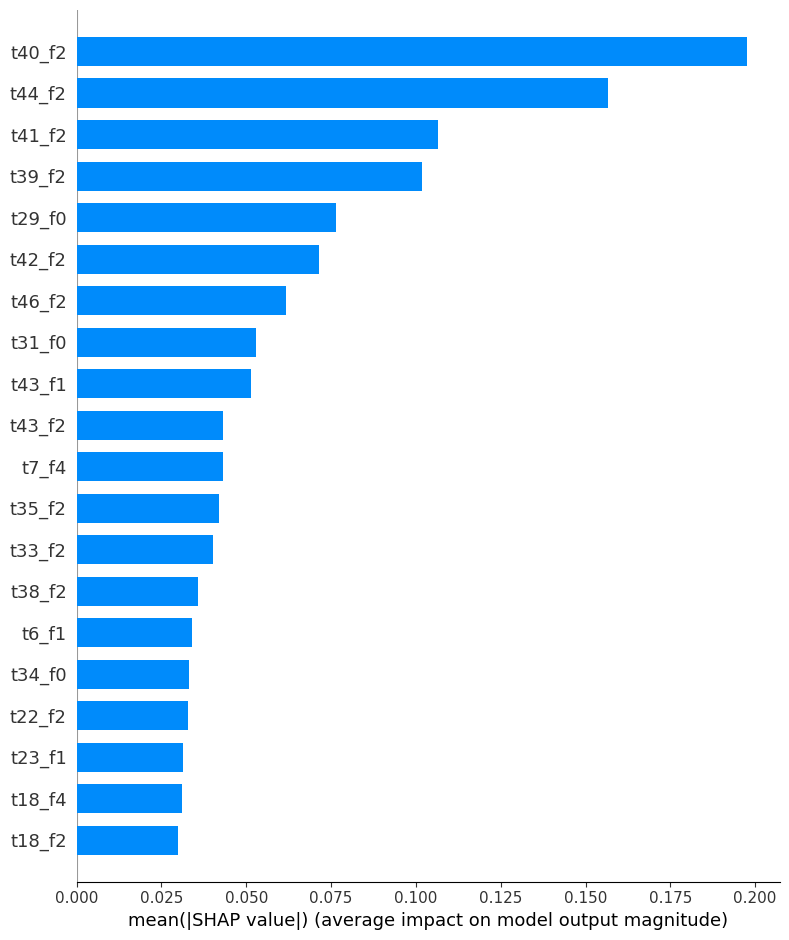

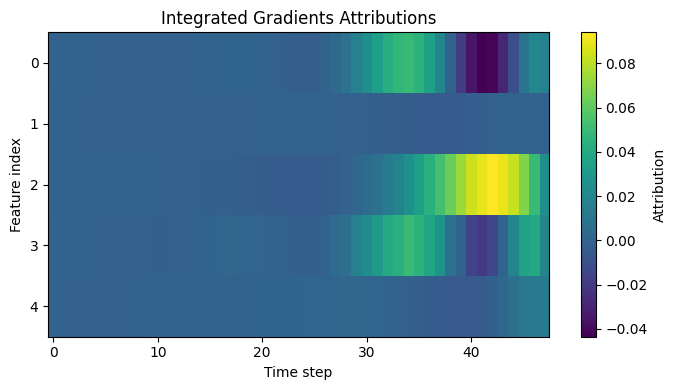


Saved dataset to data.csv and model to forecasting_model.h5


In [3]:
# ================================================================
# Advanced Time Series Forecasting Project
# ================================================================

"""
Multivariate synthetic time series + LSTM forecasting model with:
- Hyperparameter tuning
- Baseline MLP comparison
- SHAP explainability (KernelExplainer)
- Integrated Gradients
- Production-style modular code with docstrings

"""

from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, Tuple, List, Any

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import layers, models

import shap


# ===========================================================================
# 1. DATA GENERATION & PREPROCESSING
# ===========================================================================

def generate_data(n_samples: int = 1500,
                  seed: int = 42) -> pd.DataFrame:
    """
    Generate a synthetic multivariate time series dataset.

    The dataset has 5 features (f1–f5) and 1 target column ("target")
    with clear temporal dependencies.
    """
    np.random.seed(seed)
    t = np.arange(n_samples)

    # Feature 1: daily seasonality
    f1 = 10 * np.sin(2 * np.pi * t / 24)

    # Feature 2: weekly seasonality
    f2 = 4 * np.sin(2 * np.pi * t / (24 * 7))

    # Feature 3: upward trend + noise
    f3 = 0.03 * t + np.random.normal(scale=0.2, size=n_samples)

    # Feature 4: nonlinear combination of f1 and f2 + noise
    f4 = 0.5 * f1 + 0.3 * f2 + np.random.normal(scale=0.5, size=n_samples)

    # Feature 5: random walk (cumulative noise)
    f5 = np.cumsum(np.random.normal(scale=0.3, size=n_samples))

    # Target: nonlinear function of lagged features + noise
    y = (
        0.4 * np.roll(f1, 1) +   # previous step of f1
        0.3 * np.roll(f3, 2) +   # 2-steps-lagged f3
        0.2 * f4 +               # current f4
        np.random.normal(scale=0.3, size=n_samples)
    )

    df = pd.DataFrame({
        "f1": f1,
        "f2": f2,
        "f3": f3,
        "f4": f4,
        "f5": f5,
        "target": y,
    })

    return df


def create_sequences(X: np.ndarray,
                     y: np.ndarray,
                     seq_len: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert a 2D feature matrix into 3D sequences for sequence models.

    Each output sample consists of `seq_len` consecutive time steps of X
    and the target is the value of y.
    """
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i + seq_len])
        ys.append(y[i + seq_len])
    return np.array(Xs), np.array(ys)


def preprocess(df: pd.DataFrame,
               seq_len: int = 48,
               train_ratio: float = 0.7,
               val_ratio: float = 0.15
               ) -> Tuple[np.ndarray, np.ndarray,
                          np.ndarray, np.ndarray,
                          np.ndarray, np.ndarray,
                          StandardScaler]:
    """
    Scale data, create sequences, and split into train/val/test sets.
    """
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df.values)

    X_all = scaled[:, :-1]  # features
    y_all = scaled[:, -1]   # target

    X_seq, y_seq = create_sequences(X_all, y_all, seq_len)

    n = len(X_seq)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))

    X_train = X_seq[:train_end]
    y_train = y_seq[:train_end]

    X_val = X_seq[train_end:val_end]
    y_val = y_seq[train_end:val_end]

    X_test = X_seq[val_end:]
    y_test = y_seq[val_end:]

    return X_train, y_train, X_val, y_val, X_test, y_test, scaler


# ===========================================================================
# 2. MODEL DEFINITION & TRAINING (WITH SIMPLE HYPERPARAMETER TUNING)
# ===========================================================================

def build_lstm(seq_len: int,
               n_features: int,
               hidden_units: int = 64,
               dropout_rate: float = 0.2) -> tf.keras.Model:
    """
    Build a stacked LSTM regression model.
    """
    model = models.Sequential([
        layers.Input(shape=(seq_len, n_features)),
        layers.LSTM(hidden_units, return_sequences=True),
        layers.Dropout(dropout_rate),
        layers.LSTM(hidden_units),
        layers.Dropout(dropout_rate),
        layers.Dense(1),
    ])

    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mae"],
    )
    return model


def evaluate_predictions(y_true: np.ndarray,
                         y_pred: np.ndarray) -> Dict[str, float]:
    """
    Compute RMSE, MAE, and MAPE for given predictions.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)

    # Avoid division by zero in MAPE
    denom = np.where(y_true == 0, 1e-8, y_true)
    mape = float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

    return {
        "mse": float(mse),
        "rmse": rmse,
        "mae": float(mae),
        "mape": mape,
    }


def train_lstm_with_tuning(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    seq_len: int,
    n_features: int,
    param_grid: Dict[str, List[Any]] | None = None,
    epochs: int = 10,
    batch_size: int = 32,
) -> Tuple[tf.keras.Model, Dict[str, Any], Dict[str, float]]:
    """
    Train an LSTM model with a simple manual hyperparameter search.
    """
    if param_grid is None:
        param_grid = {
            "hidden_units": [32, 64],
            "dropout_rate": [0.1, 0.2],
        }

    best_model = None
    best_params: Dict[str, Any] = {}
    best_scores: Dict[str, float] = {"rmse": np.inf}

    for hidden in param_grid["hidden_units"]:
        for dropout in param_grid["dropout_rate"]:
            print(f"\nTraining LSTM with hidden_units={hidden}, dropout={dropout}")
            model = build_lstm(seq_len, n_features,
                               hidden_units=hidden,
                               dropout_rate=dropout)

            model.fit(
                X_train,
                y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                verbose=0,   # set to 1 if you want detailed logs
            )

            val_pred = model.predict(X_val, verbose=0).flatten()
            scores = evaluate_predictions(y_val, val_pred)

            print(f"Validation RMSE={scores['rmse']:.4f}, "
                  f"MAE={scores['mae']:.4f}, MAPE={scores['mape']:.2f}%")

            if scores["rmse"] < best_scores["rmse"]:
                best_scores = scores
                best_params = {
                    "hidden_units": hidden,
                    "dropout_rate": dropout,
                }
                best_model = model

    print("\nBest hyperparameters:", best_params)
    print("Best validation scores:", best_scores)

    assert best_model is not None, "Hyperparameter search did not produce a model."
    return best_model, best_params, best_scores


# ===========================================================================
# 3. BASELINE MODEL (MLP)
# ===========================================================================

def train_baseline_mlp(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    hidden_layers: Tuple[int, ...] = (64, 64),
    max_iter: int = 500,
) -> Tuple[MLPRegressor, Dict[str, float]]:
    """
    Train a baseline MLPRegressor on flattened sequences.
    """
    # Flatten 3D sequence input into 2D feature matrix
    X_train_flat = X_train.reshape(len(X_train), -1)
    X_test_flat = X_test.reshape(len(X_test), -1)

    model = MLPRegressor(
        hidden_layer_sizes=hidden_layers,
        max_iter=max_iter,
        random_state=42,
    )
    model.fit(X_train_flat, y_train)
    preds = model.predict(X_test_flat)

    scores = evaluate_predictions(y_test, preds)
    return model, scores


# ===========================================================================
# 4. EXPLAINABILITY: SHAP & INTEGRATED GRADIENTS
# ===========================================================================

def explain_with_shap(
    model: tf.keras.Model,
    X_train: np.ndarray,
    X_test: np.ndarray,
    seq_len: int,
    n_features: int,
    n_background: int = 50,
    n_samples: int = 10,
    nsamples_kernel: int = 100,
) -> None:
    """
    Apply SHAP KernelExplainer to the trained LSTM model.

    It flattens the sequences for SHAP input and then reshapes them
    back inside the prediction function.
    """
    print("\nRunning SHAP KernelExplainer (this may take a bit)...")

    X_train_flat = X_train.reshape(len(X_train), -1)
    X_test_flat = X_test.reshape(len(X_test), -1)

    background = X_train_flat[:n_background]
    test_samples = X_test_flat[:n_samples]

    def shap_predict(X_flat: np.ndarray) -> np.ndarray:
        """Wrapper for SHAP: reshape flat input back to 3D for LSTM."""
        X_reshaped = X_flat.reshape((-1, seq_len, n_features))
        preds = model.predict(X_reshaped, verbose=0).flatten()
        return preds

    explainer = shap.KernelExplainer(shap_predict, background)
    shap_values = explainer.shap_values(test_samples, nsamples=nsamples_kernel)

    feature_names = [
        f"t{t}_f{f}" for t in range(seq_len) for f in range(n_features)
    ]

    # Global summary plot (bar) – importance across all flattened features
    shap.summary_plot(
        shap_values,
        test_samples,
        plot_type="bar",
        feature_names=feature_names,
        show=True,
    )


def integrated_gradients(
    model: tf.keras.Model,
    sample: np.ndarray,
    baseline: np.ndarray | None = None,
    steps: int = 50,
) -> np.ndarray:
    """
    Compute Integrated Gradients for a single input sequence.
    """
    if baseline is None:
        baseline = np.zeros_like(sample)

    # Linearly interpolate between baseline and sample
    interpolated = np.array([
        baseline + (i / steps) * (sample - baseline)
        for i in range(steps + 1)
    ])  # (steps+1, seq_len, n_features)

    grads = []
    for x in interpolated:
        x_tensor = tf.convert_to_tensor(x[np.newaxis, ...], dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(x_tensor)
            pred = model(x_tensor)
        grad = tape.gradient(pred, x_tensor).numpy()
        grads.append(grad[0])

    avg_grad = np.mean(np.array(grads), axis=0)
    attributions = avg_grad * (sample - baseline)
    return attributions


def plot_ig_heatmap(attributions: np.ndarray) -> None:
    """
    Plot a heatmap of Integrated Gradients attributions.
    """
    plt.figure(figsize=(7, 4))
    plt.imshow(attributions.T, aspect="auto")
    plt.colorbar(label="Attribution")
    plt.xlabel("Time step")
    plt.ylabel("Feature index")
    plt.title("Integrated Gradients Attributions")
    plt.tight_layout()
    plt.show()


# ===========================================================================
# 5. UTILITY: SAVING MODEL & DATA, MAIN PIPELINE
# ===========================================================================

def save_artifacts(df: pd.DataFrame,
                   model: tf.keras.Model,
                   data_path: str = "data.csv",
                   model_path: str = "forecasting_model.h5") -> None:
    """
    Save dataset and trained model to disk.
    """
    df.to_csv(data_path, index=False)
    model.save(model_path)
    print(f"\nSaved dataset to {data_path} and model to {model_path}")


def main() -> None:
    """
    Main end-to-end pipeline:
    - Generate data
    - Preprocess & create sequences
    - Hyperparameter-tune and train LSTM
    - Evaluate on test set
    - Train and evaluate baseline MLP
    - Apply SHAP and Integrated Gradients
    - Save artifacts
    """
    # ----------------------------
    # Step 1: Data generation
    # ----------------------------
    df = generate_data(n_samples=1500, seed=42)
    print("Generated data shape:", df.shape)

    seq_len = 48
    X_train, y_train, X_val, y_val, X_test, y_test, scaler = preprocess(
        df,
        seq_len=seq_len,
    )
    n_features = X_train.shape[2]

    print("Train sequences:", X_train.shape)
    print("Val sequences  :", X_val.shape)
    print("Test sequences :", X_test.shape)

    # ----------------------------
    # Step 2: LSTM + hyperparameter tuning
    # ----------------------------
    best_lstm, best_params, best_val_scores = train_lstm_with_tuning(
        X_train,
        y_train,
        X_val,
        y_val,
        seq_len=seq_len,
        n_features=n_features,
        epochs=10,
        batch_size=32,
    )

    # Evaluate best LSTM on test set
    test_pred = best_lstm.predict(X_test, verbose=0).flatten()
    lstm_test_scores = evaluate_predictions(y_test, test_pred)

    print("\nLSTM test metrics:")
    for k, v in lstm_test_scores.items():
        print(f"  {k.upper()}: {v:.4f}")

    # Simple forecast vs actual plot
    plt.figure(figsize=(8, 4))
    plt.plot(y_test[:300], label="Actual")
    plt.plot(test_pred[:300], label="LSTM Predicted")
    plt.title("LSTM Forecast vs Actual (Test Set Sample)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ----------------------------
    # Step 3: Baseline MLP
    # ----------------------------
    mlp_model, mlp_scores = train_baseline_mlp(
        X_train,
        y_train,
        X_test,
        y_test,
        hidden_layers=(64, 64),
    )
    print("\nBaseline MLP test metrics:")
    for k, v in mlp_scores.items():
        print(f"  {k.upper()}: {v:.4f}")

    # ----------------------------
    # Step 4: Explainability
    # ----------------------------
    explain_with_shap(
        best_lstm,
        X_train,
        X_test,
        seq_len=seq_len,
        n_features=n_features,
    )

    # Integrated Gradients for one test sample
    ig_attr = integrated_gradients(best_lstm, X_test[0])
    plot_ig_heatmap(ig_attr)

    # ----------------------------
    # Step 5: Save artifacts
    # ----------------------------
    save_artifacts(df, best_lstm)


# Run the whole pipeline only when this file is executed directly
if __name__ == "__main__":
    main()